In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
import os
from tqdm import tqdm
from glob import glob
import pickle
from collections import defaultdict

import skimage
import numpy as np
import pandas as pd
import scipy
import numpy_indexed as npi

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

import cv2

In [3]:
import torch
from torch.utils.data.sampler import Sampler
import torch.nn.functional as F

import torchvision.models as models

In [4]:
import sys

sys.path.append('..')
import src.utils.dataset as ds
from src.configs import config
from src.utils import learner as lrn
from src.utils import lr_finder as lrf
from src.utils import augmentations as augs
from src.utils import visualisation

%load_ext autoreload
%autoreload 2

In [5]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [27]:
def measure_f1(predictions, labels, threshs=.5):
    if isinstance(threshs, float):
        threshs = [threshs] * labels.shape[-1]
    return [
        sklearn.metrics.f1_score(labels[:, i], predictions[:, i] > threshs[i]) 
        for i, el in enumerate(config.label_names_list)
    ]

# Inference

In [6]:
test_df = pd.read_csv(os.path.join(config.PATHS['CSV'], 'sample_submission.csv'))
for name in config.label_names_list + ['Predicted', 'Target']:
    test_df[name] = 0

In [7]:
def prepare_learner(fold, checkpoint):
    model = models.resnet101(pretrained=True)
    model = lrn.set_io_dims(model, in_channels=4, out_channels=28, dropout=PARAMS['DROPOUT'])
    model = lrn.get_model(model, checkpoint=checkpoint, devices=PARAMS['CUDA_DEVICES'])
    model.module.eval()

    loss = FocalLoss(gamma=2)

    opt = torch.optim.Adam(model.parameters(), lr=4e-4, weight_decay=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=-1)
    learner = lrn.Learner(model=model, opt=opt, loss=loss)
    return learner

def prepare_data(fold):
    folds = ds.get_folds(config.PARAMS['NB_FOLDS'])
    _, valid_dataset = ds.get_datasets(folds, fold)

    test_dataset = ds.ProteinDataset(
        test_df, 
        config.PATHS['TEST'], 
        config.label_names_list, 
        augmentations=None
    )
    return valid_dataset, test_dataset


In [8]:
def infer(model, idx, data, predicts, labels=None):
    with torch.no_grad():
        image = data['image'].unsqueeze(0)
        image = augs.get_crops(image, config.PARAMS['SIDE'] + 64)
        image = augs._rotate_mirror_do(image)

        image = torch.tensor(image)
        image = torch.autograd.Variable(image).cuda()
        predict = model(image)
        predict = torch.sigmoid(predict)
        predict = predict.reshape(8, 5, len(config.label_names_list))
        predicts[idx] = predict.mean(0).data.cpu().numpy()

        image = image.data.cpu()
        if labels is not None:
            labels[idx] = data['label']


In [9]:
def orchestrate_inference(fold, checkpoints_pth, epoch):
    template_path = 'fold_{}_checkpoint.epoch_{}'
    path = os.path.join(checkpoints_pth, template_path)
    dump_path = os.path.join(checkpoints_pth, '{}_fold_{}')
    
    history = pickle.load(open(path.format(fold, 'loss'), 'rb'))
    plt.figure(figsize=(15,10))
    sns.barplot(y=label_names_list, x=history['valid_losses'][epoch]['f1_score']);
    plt.show()

    formated_train = format_history(history['train_losses'])
    formated_valid = format_history(history['valid_losses'])
    plot_losses(formated_train, formated_valid)
    
    learner = prepare_learner(fold, path.format(fold, epoch))
    valid_dataset, test_dataset = prepare_data(fold)
    

    predicts = np.zeros(shape=(len(test_dataset), 5, len(config.label_names_list)))
    try:
        for idx in tqdm(range(len(test_dataset))):
            infer(learner.model, idx, test_dataset[idx], predicts, labels=None)
    except Exception as e:
        print(e)
        print('idx: {}'.format(idx))
    np.save(dump_path.format('test_predicts', fold), predicts)
    test_dataset.keys.to_csv(dump_path.format('test_keys', fold))


    valid_predicts = np.zeros(shape=(len(valid_dataset), 5, len(config.label_names_list)))
    valid_labels = np.zeros(shape=(len(valid_dataset), len(config.label_names_list)))
    try:
        for idx in tqdm(range(len(valid_dataset))):
            infer(learner.model, idx, valid_dataset[idx], valid_predicts, labels=valid_labels)
    except Exception as e:
        print(e)
        print('idx: {}'.format(idx))
    np.save(dump_path.format('valid_predicts', fold), valid_predicts)
    np.save(dump_path.format('valid_labels', fold), valid_labels)
    valid_dataset.keys.to_csv(dump_path.format('valid_keys', fold))


In [10]:
epoch = 49
checkpoints_pth = '../data/models/resnet101_side_384_pilo/'

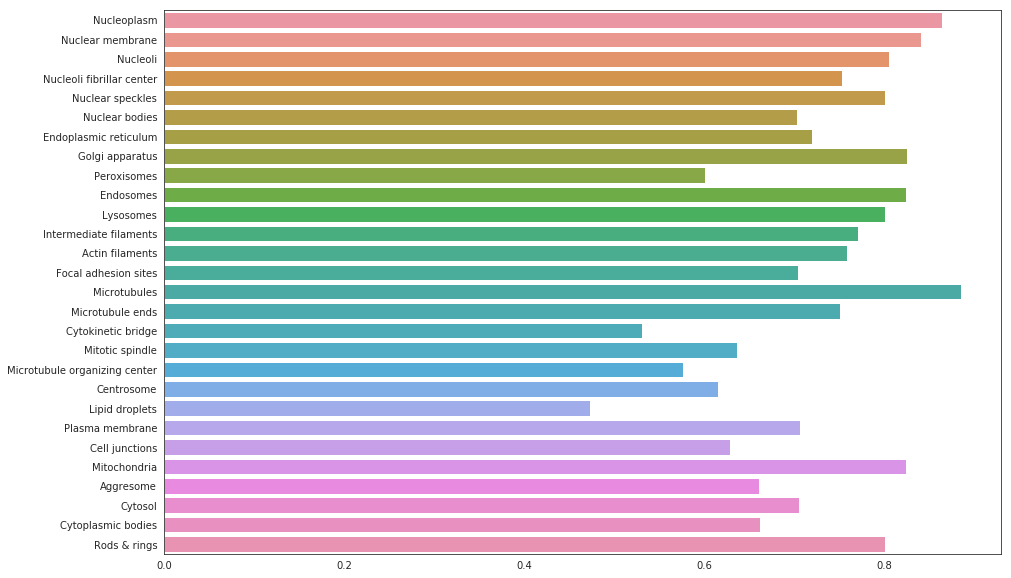

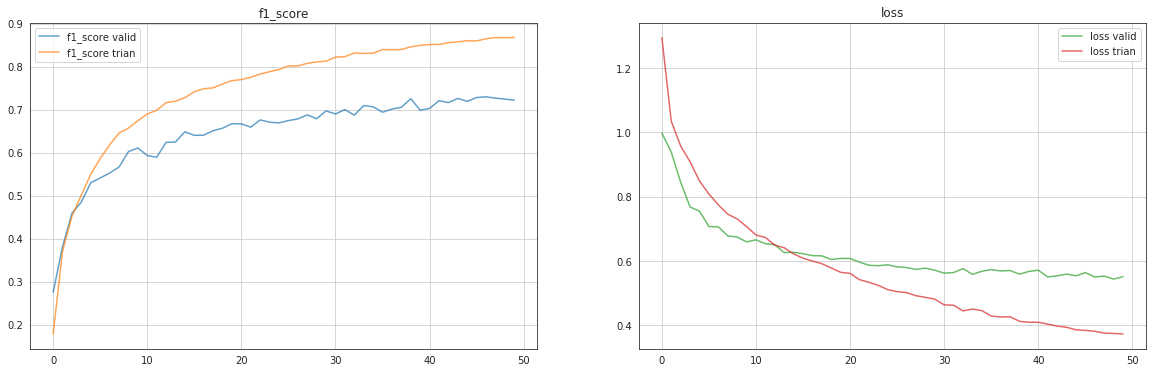

In [ ]:
# for fold in range(config.PARAMS['NB_FOLDS']):
#     orchestrate_inference(fold, checkpoints_pth, epoch)

In [81]:
dump_path = os.path.join(checkpoints_pth, '{}_fold_{}')
template_path = 'fold_{}_checkpoint.epoch_{}'
path = os.path.join(checkpoints_pth, template_path)


valid_predicts = list()
valid_labels = list()
for fold in range(config.PARAMS['NB_FOLDS']):
    valid_predicts.append(np.load(dump_path.format('valid_predicts', fold) + '.npy'))
    valid_labels.append(np.load(dump_path.format('valid_labels', fold) + '.npy'))

predicts = list()
for fold in range(config.PARAMS['NB_FOLDS']):
    predicts.append(np.load(dump_path.format('test_predicts', fold) + '.npy'))
predicts = np.stack(predicts)


In [82]:
def get_threshold(roc_curve):
    vec = np.ones(shape=(2, ))
    vec /= np.linalg.norm(vec, ord=2)
    pts = vec.reshape(2, 1) * np.dot(vec, roc_curve[:2])
    distances = np.linalg.norm(roc_curve[:2] - pts, ord=2, axis=0)
    idx = np.argmax(distances)
    return roc_curve[-1, idx], idx

In [80]:
valid_predicts.shape

(5,)

In [36]:
labels_ = np.concatenate(valid_labels)
preds_ = np.concatenate(valid_predicts).max(1)

# labels_ = history['valid_losses'][epoch]['labels'] # np.concatenate([stamp['labels'] for stamp in history['valid_losses']])
# preds_ = history['valid_losses'][epoch]['predictions'] # np.concatenate([stamp['predictions'] for stamp in history['valid_losses']])

In [ ]:
valid_predicts

/home/vessemer/anaconda3/envs/cxr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


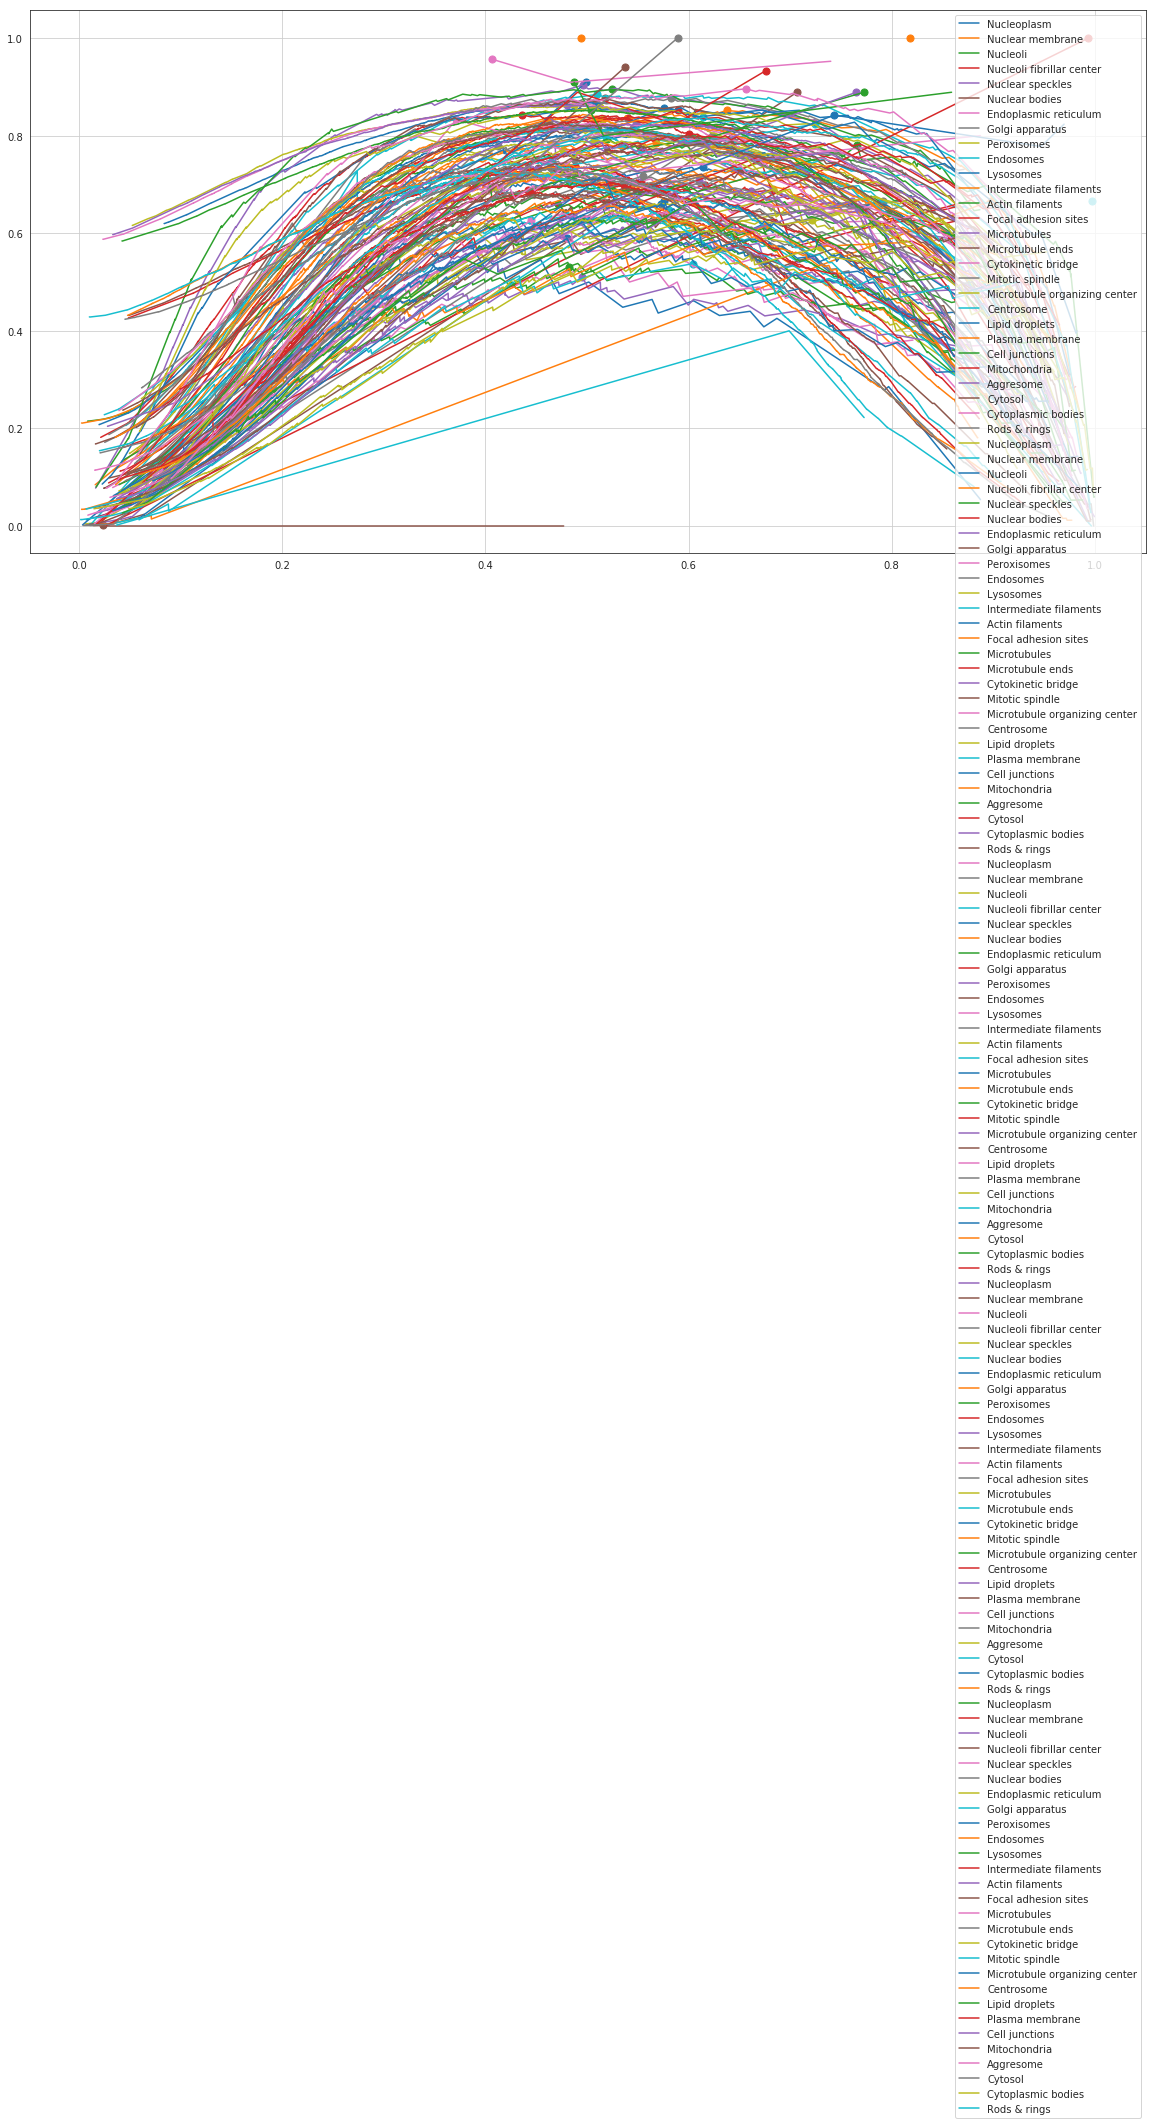

In [39]:
threshs = dict()

plt.figure(figsize=(20, 10))
for fold in range(config.PARAMS['NB_FOLDS']):
    threshs[fold] = dict()
    predicts_ = valid_predicts[fold].max(1)

    for i in range(valid_labels[fold].shape[-1]):
        roc_curve = sklearn.metrics.roc_curve(valid_labels[fold][:, i], predicts_[:, i])
        roc_curve = np.array(roc_curve)
        f1_scores = [sklearn.metrics.f1_score(valid_labels[fold][:, i], predicts_[:, i] >= t) for t in roc_curve[-1]]
        idx = np.argmax(f1_scores)
        threshs[fold][i] = roc_curve[-1][idx]
        plt.plot(roc_curve[-1][1:-1], f1_scores[1:-1], label=config.label_names[i])
        plt.scatter(roc_curve[-1, idx], f1_scores[idx], marker='o', s=50)

plt.legend()
plt.grid()
plt.show()

# threshs = np.array([threshs[i] for i, el in enumerate(config.label_names_list)])

In [47]:
predicts = predicts.max(2)

In [48]:
predicts.shape

(5, 11702, 28)

In [51]:
for fold in range(config.PARAMS['NB_FOLDS']):
    ts = np.array([
        threshs[fold][i]
        for i, el in enumerate(config.label_names_list)
    ])
    predicts[fold] -= ts

In [55]:
predicts = predicts.mean(0) > 0

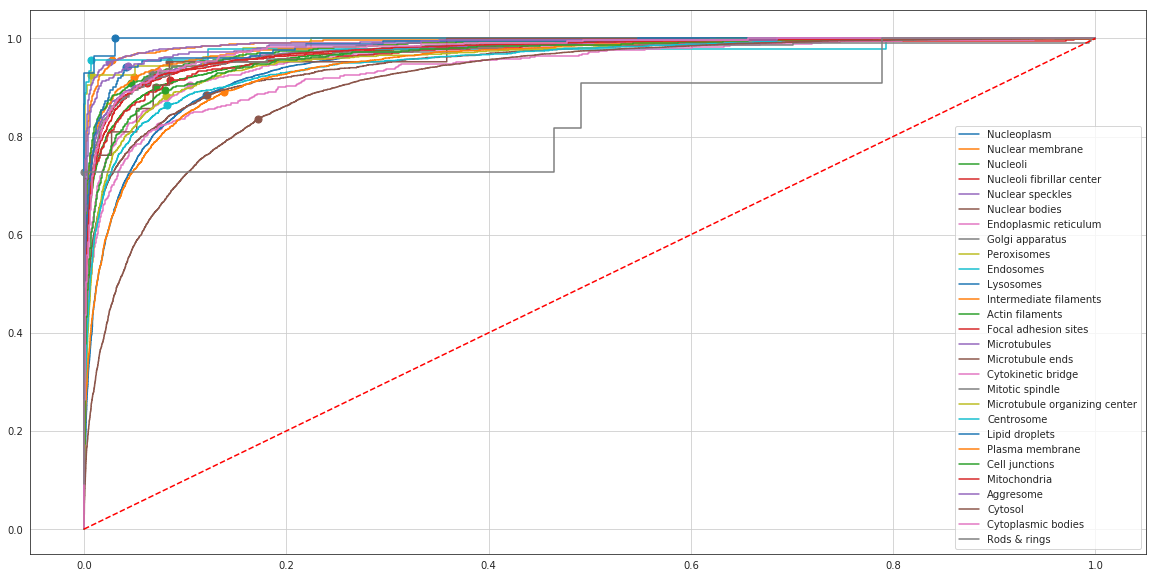

In [16]:
threshs = dict()
plt.figure(figsize=(20, 10))
for i in range(labels_.shape[-1]):
    roc_curve = sklearn.metrics.roc_curve(labels_[:, i], preds_[:, i])
    roc_curve = np.array(roc_curve)
    threshs[i], idx = get_threshold(roc_curve)
    plt.plot(roc_curve[0], roc_curve[1], label=config.label_names[i])
    plt.scatter(roc_curve[0, idx], roc_curve[1, idx], marker='o', s=50)

plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), 'r--')
plt.legend()
plt.grid()
plt.show()

threshs = np.array([threshs[i] for i, el in enumerate(config.label_names_list)])

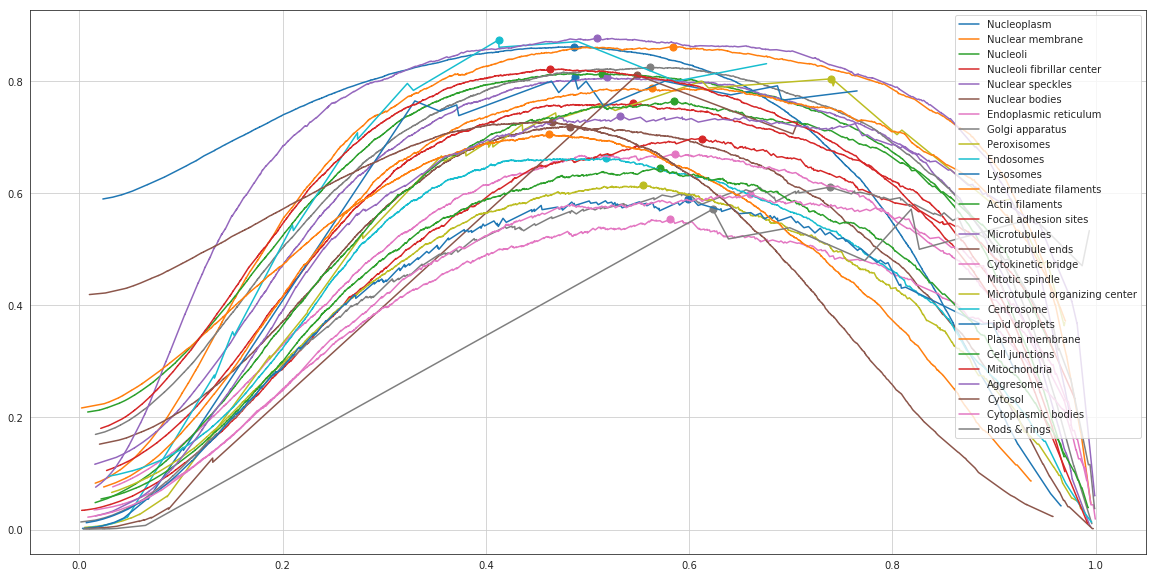

In [17]:
threshs = dict()
plt.figure(figsize=(20, 10))
for i in range(labels_.shape[-1]):
    roc_curve = sklearn.metrics.roc_curve(labels_[:, i], preds_[:, i])
    roc_curve = np.array(roc_curve)
    f1_scores = [sklearn.metrics.f1_score(labels_[:, i], preds_[:, i] >= t) for t in roc_curve[-1]]
    idx = np.argmax(f1_scores)
    threshs[i] = roc_curve[-1][idx]
    plt.plot(roc_curve[-1][1:-1], f1_scores[1:-1], label=config.label_names[i])
    plt.scatter(roc_curve[-1, idx], f1_scores[idx], marker='o', s=50)

plt.legend()
plt.grid()
plt.show()

threshs = np.array([threshs[i] for i, el in enumerate(config.label_names_list)])

In [56]:
folds = ds.get_folds(config.PARAMS['NB_FOLDS'])
_, valid_dataset = ds.get_datasets(folds, fold)

test_dataset = ds.ProteinDataset(
    test_df, 
    config.PATHS['TEST'], 
    config.label_names_list, 
    augmentations=None
)

In [57]:
history = pickle.load(open(path.format(fold, 'loss'), 'rb'))

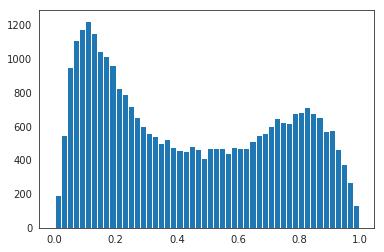

In [58]:
plt.hist(preds_[:, 0], 50);

In [59]:
np.mean(measure_f1(preds_, labels_, threshs=.5))

0.7195976984726461

In [61]:
# np.mean(measure_f1(preds_, labels_, threshs=threshs))

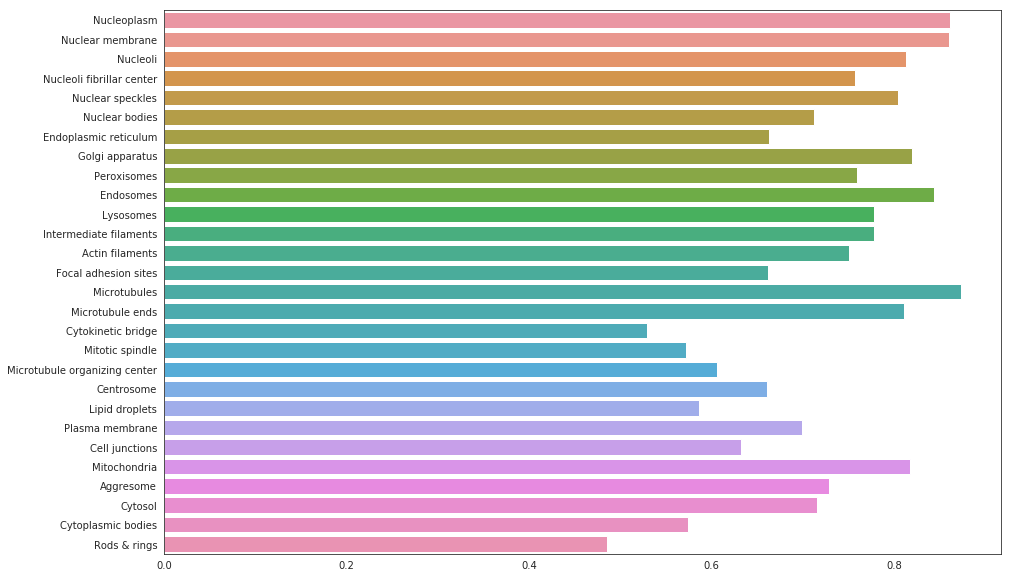

In [62]:
plt.figure(figsize=(15,10))
sns.barplot(y=config.label_names_list, x=measure_f1(preds_, labels_));
plt.show()

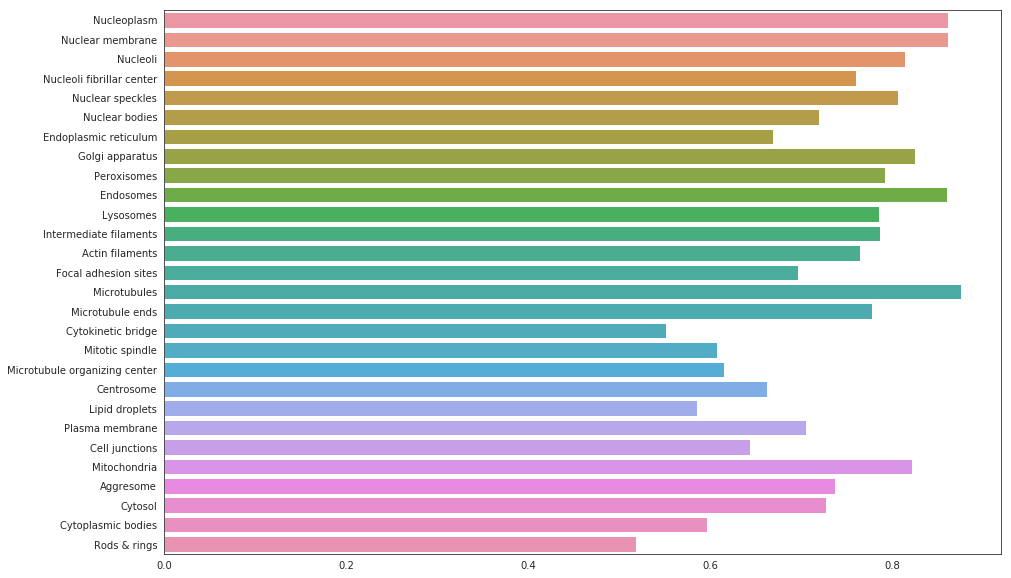

In [30]:
plt.figure(figsize=(15,10))
sns.barplot(y=config.label_names_list, x=measure_f1(preds_, labels_, threshs=threshs));
plt.show()

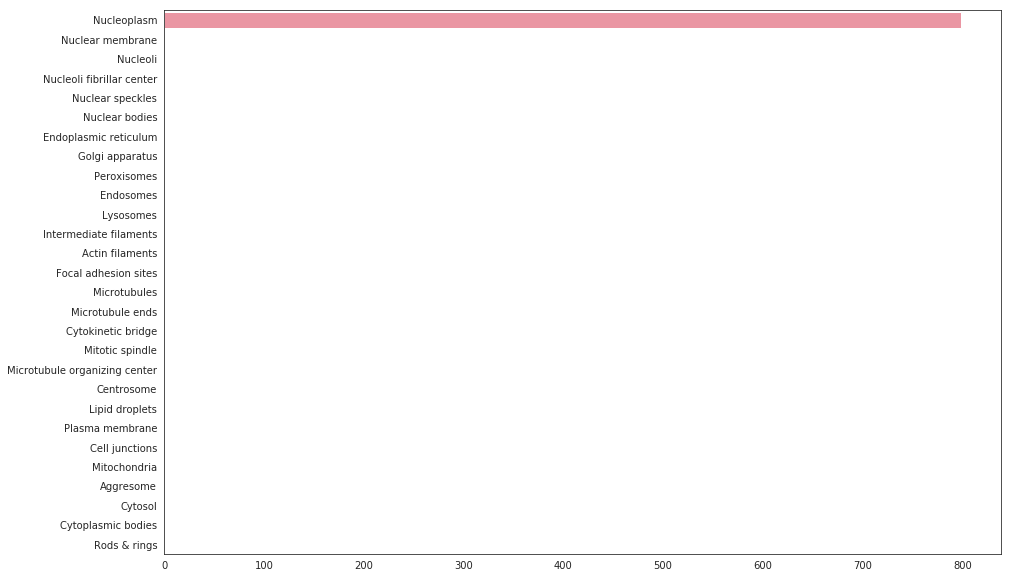

In [64]:
threshold = 0
predictions = predicts#.max(2).mean(0) # format_predictions(results)['predictions']


selected = predictions > threshold
idxs_mask = ~np.any(selected, axis=1)
best_outs = np.argmax(predictions[idxs_mask], axis=1)
selected[idxs_mask, best_outs] = True
counts = np.zeros(shape=(len(config.label_names_list, )))
counts[:max(best_outs) + 1] = np.bincount(best_outs)

plt.figure(figsize=(15, 10))
sns.barplot(y=config.label_names_list, x=counts);
plt.show()

idxs = np.array(np.where(selected))
groups = npi.group_by(idxs[0]).split(idxs[1])

In [65]:
for idx, el in tqdm(zip(np.unique(idxs[0]), groups)):
    # test_datagen.dataset.labels.loc[idx, [label_names[e] for e in el]] = predictions[idx, el]
    test_dataset.labels.loc[idx, 'Predicted'] = ' '.join(['%d' % e for e in el])

11702it [00:15, 764.76it/s]


In [66]:
test_dataset.labels['Id'] = test_dataset.labels.index
df = test_dataset.labels[['Id', 'Predicted']]
df.to_csv('simple.csv', index=False)

In [67]:
df[df.Predicted.isna()].shape

(0, 2)

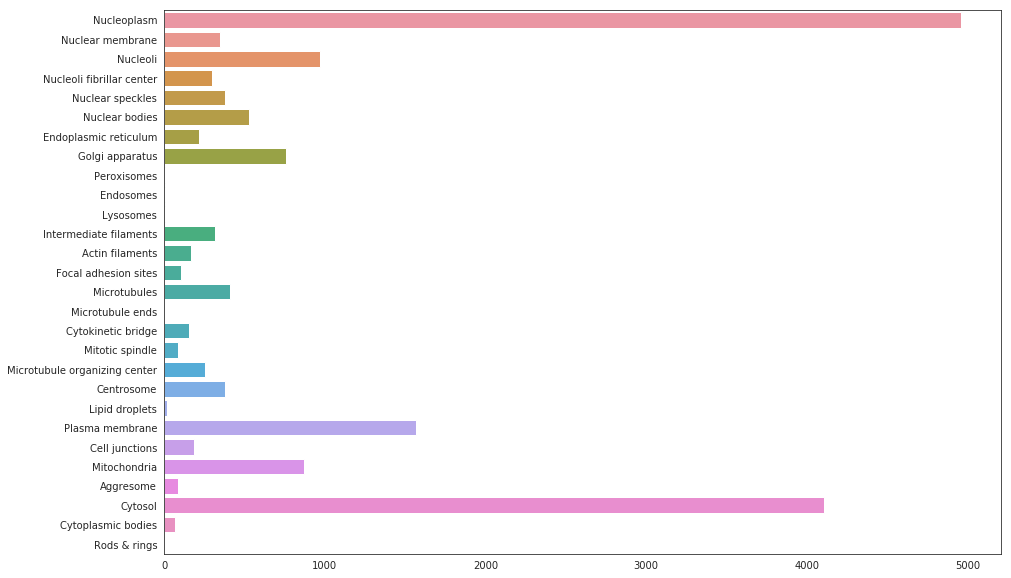

In [72]:
counts = np.bincount(np.where(predicts > 0)[1])

plt.figure(figsize=(15, 10))
sns.barplot(y=config.label_names_list, x=counts);
plt.show()